# Building Models to Predict Weekly Gross Revenue

Having explored the dataset, we will now start the model-building part of the project. The aim is to predict weekly gross revenue. This project will build 4 different models and see which one performs best. Because this project deals with Gross Revenue, we will be using Regression models.

**MODELING OBJECTIVES**

- Predict Weekly Gross Revenue
- Build 5 different Models and see which one is the most high performing

**Model 1: Linear Regression**
- This Model will serve as our second "baseline".

**Model 2: Random Forest Regressor**
- This model doesn't assume linear relationship, which will be good to compare against linear regression. Helpful for complex relationships within the data

**Model 3: KNN Regressor**
- This Model will be helpful in uncovering local trends to predict Weekly Gross, considering Broadway's seasonality.

**Model 4: Decision Tree**
- Versatile, Interpretable
- Might overfit but we can compare this model with the other 3

In [2181]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2182]:
#Make DataSet -- Import from EDA Notebook

In [2183]:
df = pd.read_csv('broadway_gross_data copy.csv')
df['Week'] = pd.to_datetime(df['Week'])

In [2184]:
#Data Editing -- converting numeric columns from object to int or float
numeric_cols = ['This Week Gross', 'Avg Ticket', 'Top Ticket', 'Seats Sold', 'Seats in Theatre', 'Performances', 'Previews']
for col in numeric_cols:
  df[col] = df[col].astype(str).str.replace('$', '')
  df[col] = df[col].str.replace(',', '')

  df[col] = pd.to_numeric(df[col], errors = 'coerce')

In [2185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1661 entries, 0 to 1660
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Show              1661 non-null   object        
 1   Week              1661 non-null   datetime64[ns]
 2   Theater           1661 non-null   object        
 3   This Week Gross   1661 non-null   float64       
 4   Potential Gross   0 non-null      float64       
 5   Diff $            1661 non-null   object        
 6   Avg Ticket        1661 non-null   float64       
 7   Top Ticket        1661 non-null   float64       
 8   Seats Sold        1661 non-null   int64         
 9   Seats in Theatre  1661 non-null   int64         
 10  Performances      1661 non-null   int64         
 11  Previews          1661 non-null   int64         
 12  % Cap             1661 non-null   object        
 13  Diff % cap        1661 non-null   object        
 14  Genre             1661 n

In [2186]:
#df -- uncomment to check dataframe

In [2187]:
#Preprocessing template

#X features: "Avg Ticket Price", "Seats Sold", and "Genre"
X_features = ['Avg Ticket', 'Genre', 'Season', 'Seats in Theatre']
X = df[X_features]

target = 'This Week Gross'
y = df[target]

#split into 80% train 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 22)

ohe = OneHotEncoder(drop = 'first') #for categorical data
sscaler = StandardScaler() #for numerical data

#create a transformer that will encode categorical variables and standard scale other features

transformer = make_column_transformer((ohe, ['Genre','Season']), remainder = sscaler)
#transformer is ready to be put in a pipeline and fit in a model

Note: at first I generalized the data preprocessing, but quickly realized that different features worked with different models. So I went on to redo the preprocessing before fitting all my models.

In [2188]:
#X.shape, y.shape
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1328, 4), (1328,), (333, 4), (333,))

In [2189]:
#record results to compare how the model works
results = []

###Baseline

In [2190]:
#baseline = mean of y var
baseline_preds = np.ones(len(y)) * y.mean()
print(y.mean())
mean_squared_error(y, baseline_preds)

#print MSE and RMSE
print(f'MSE: {mean_squared_error(y, baseline_preds)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y, baseline_preds))}') #we will use RMSE because it will fit the context better
#example = "error of $578,506 in weekly gross"

1101524.25743528
MSE: 334670160593.26263
RMSE: 578506.837118856


###Model 1: Linear Regression

In [2191]:
#Preprocessing

X_features = ['Avg Ticket', 'Genre', 'Month', 'Season', 'Number of Awards', 'Top Ticket', 'Seats in Theatre']
X = df[X_features]

target = 'This Week Gross'
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 22)

ohe = OneHotEncoder(drop = 'first')
sscaler = StandardScaler()

#create a transformer that will encode categorical variables and standard scale other features

transformer = make_column_transformer((ohe, ['Genre','Season', 'Month']), remainder = sscaler)

In [2192]:
#instantiate
model = LinearRegression()

#build pipeline
lr_pipe = Pipeline([('transformer', transformer), ('model', model)])

#fit
lr_pipe.fit(X_train, y_train)

#getting the ohe from the pipeline
ohe_in_pipe = lr_pipe.named_steps['transformer'].transformers_[0][1]

#avoid errors during prediction
ohe_in_pipe.set_params(handle_unknown='ignore')

OneHotEncoder(drop='first', handle_unknown='ignore')

In [2193]:
#make predictions
y_pred = lr_pipe.predict(X_test)

y_pred_train = lr_pipe.predict(X_train)

#add results
results.append({
    'Model': 'Linear Regression',
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'Train R2': r2_score(y_train, y_pred_train),
    'Test R2': r2_score(y_test, y_pred),
    'Overfit?': (np.sqrt(mean_squared_error(y_test, y_pred)) > np.sqrt(mean_squared_error(y_train, y_pred_train)))
})

In [2194]:
#print X features
print(lr_pipe.named_steps['transformer'].get_feature_names_out())

['onehotencoder__Genre_Comedy' 'onehotencoder__Genre_Drama'
 'onehotencoder__Genre_Musical' 'onehotencoder__Genre_One Act'
 'onehotencoder__Genre_Original' 'onehotencoder__Genre_Play'
 'onehotencoder__Genre_Revival' 'onehotencoder__Season_Spring'
 'onehotencoder__Season_Summer' 'onehotencoder__Season_Winter'
 'onehotencoder__Month_2' 'onehotencoder__Month_3'
 'onehotencoder__Month_4' 'onehotencoder__Month_5'
 'onehotencoder__Month_6' 'onehotencoder__Month_7'
 'onehotencoder__Month_8' 'onehotencoder__Month_9'
 'onehotencoder__Month_10' 'onehotencoder__Month_11'
 'onehotencoder__Month_12' 'remainder__Avg Ticket'
 'remainder__Number of Awards' 'remainder__Top Ticket'
 'remainder__Seats in Theatre']


In [2195]:
#check model performance
#intercept and slope
print(f'Coefficient: {lr_pipe.named_steps["model"].coef_}')
print(f'Intercept: {lr_pipe.named_steps["model"].intercept_}')
print(f'Test MSE: {mean_squared_error(y_test, y_pred)}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train))}')

#making a train and predict on training set to compare the R^2 with test score
print(f'Train R^2: {r2_score(y_train, y_pred_train)}')
print(f'Test R^2: {r2_score(y_test, y_pred)}')

Coefficient: [ 119723.03792398  135125.75475037   34514.06253998  105127.28185974
   63509.81974576 -158490.65119331  -31764.81400938   17325.64447136
   28661.04085226   12914.42931877    2378.44059726   -3681.67766497
    7976.13899879   13031.18313754  -20546.5725344    36099.73957537
   13107.87381129  -30825.247914    -14213.63863298  -13862.22809542
   45086.60523798  424539.62615902   38633.27029813   -4901.69106352
  296528.3962803 ]
Intercept: 1026946.7140871688
Test MSE: 25006854209.154354
Test RMSE: 158135.5564354657
Train RMSE: 182632.3040452306
Train R^2: 0.8997500753267593
Test R^2: 0.926978935403707


Already this model is doing better than baseline with a much lower test RMSE. The model is not overfit because train RMSE is still higher than test.


RMSE shows that the model's predictions are off by about $158,135.5 which is normal given the weekly gross is in the millions


This serves as an excellent second baseline, and we can now see if the more complex models will be better than this, meaning they will be even better models to an already excellent model.

In [2196]:
#see which features are most / least important
r = permutation_importance(lr_pipe, X_test, y_test, n_repeats = 10)
pd.DataFrame(r['importances_mean'], index = X_train.columns.tolist())

,0
Avg Ticket,1.080144
Genre,0.012925
Month,0.003382
Season,0.001231
Number of Awards,0.008627
Top Ticket,-0.000065
Seats in Theatre,0.523350


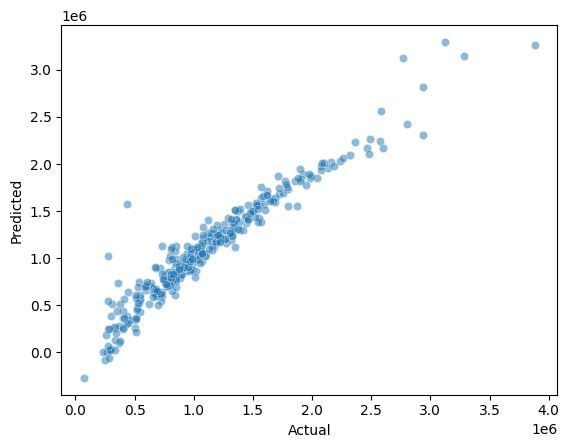

In [2197]:
sns.scatterplot(x = y_test, y = y_pred, alpha = 0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted');

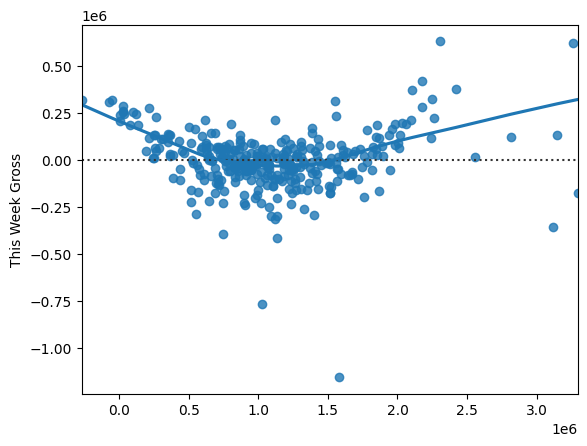

In [2198]:
#Residual Plot
sns.residplot(x = y_pred, y = y_test, lowess = True);

###Model 2: Random Forest Regressor

In [2199]:
#Preprocessing

X_features =['Avg Ticket','Number of Awards', 'Season']
X = df[X_features]

target = 'This Week Gross'
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 22)

ohe = OneHotEncoder(drop = 'first')
sscaler = StandardScaler()

#create a transformer that will encode categorical variables and standard scale other features

transformer = make_column_transformer((ohe, ['Season']), remainder = sscaler)

In [2200]:
#instantiate
rfr_model = RandomForestRegressor(random_state=20)

rfr_pipe = Pipeline([('transformer', transformer), ('model', rfr_model)])

#fit
rfr_pipe.fit(X_train, y_train)

#getting the ohe from the pipeline
ohe_in_pipe = rfr_pipe.named_steps['transformer'].transformers_[0][1]

#avoid errors during prediction
ohe_in_pipe.set_params(handle_unknown='ignore')

OneHotEncoder(drop='first', handle_unknown='ignore')

In [2201]:
#create predictions
y_pred = rfr_pipe.predict(X_test)

y_pred_train = rfr_pipe.predict(X_train)

results.append({
    'Model': 'Random Forest Regression',
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'Train R2': r2_score(y_train, y_pred_train),
    'Test R2': r2_score(y_test, y_pred),
    'Overfit?': (np.sqrt(mean_squared_error(y_test, y_pred)) > np.sqrt(mean_squared_error(y_train, y_pred_train)))
})

In [2202]:
#RMSE
print(f'MSE: {(mean_squared_error(y_test, y_pred))}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')

#MSE Train
print(f'Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train))}')

print(f'Train R^2: {r2_score(y_train, y_pred_train)}')
print(f'Test R^2: {r2_score(y_test, y_pred)}')

MSE: 35801823880.41205
Test RMSE: 189213.69897661227
Train RMSE: 80867.61317390707
Train R^2: 0.9803447709694341
Test R^2: 0.8954571705672739


In [2203]:
#see which features are important
r = permutation_importance(rfr_pipe, X_test, y_test, n_repeats = 10)
pd.DataFrame(r['importances_mean'], index = X_train.columns.tolist())

,0
Avg Ticket,1.393608
Number of Awards,0.457154
Season,0.017575


This model is way too overfit.

###Model 3: KNN Regressor

In [2204]:
#Preprocessing

X_features =['Avg Ticket', 'Genre', 'Season', 'Number of Awards', 'Top Ticket', 'Seats in Theatre']
X = df[X_features]

target = 'This Week Gross'
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 22)

ohe = OneHotEncoder(drop = 'first')
sscaler = StandardScaler()

#create a transformer that will encode categorical variables and standard scale other features

transformer = make_column_transformer((ohe, ['Genre','Season']), remainder = sscaler)

In [2205]:
knn_model = KNeighborsRegressor()

knn_pipe = Pipeline([('transformer', transformer), ('model', knn_model)])
knn_pipe.fit(X_train, y_train)

#getting the ohe from the pipeline
ohe_in_pipe = knn_pipe.named_steps['transformer'].transformers_[0][1]

#avoid errors during prediction
ohe_in_pipe.set_params(handle_unknown='ignore')

OneHotEncoder(drop='first', handle_unknown='ignore')

In [2206]:
#testing different number of neighbors
param_grid = {'model__n_neighbors': [5, 10, 15, 20, 25, 30, 50]}

#search for the best one
grid_search = GridSearchCV(knn_pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
#fit on training data
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Genre',
                                                                          'Season'])])),
                                       ('model', KNeighborsRegressor())]),
             param_grid={'model__n_neighbors': [5, 10, 15, 20, 25, 30, 50]},
             scoring='neg_mean_squared_error')

In [2207]:
grid_search.best_params_

{'model__n_neighbors': 5}

In [2208]:
knn = grid_search.best_estimator_

In [2209]:
#fit best parameter on test data
y_pred = knn.predict(X_test)
y_pred_train = knn_pipe.predict(X_train)

results.append({
    'Model': 'KNN',
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'Train R2': r2_score(y_train, y_pred_train),
    'Test R2': r2_score(y_test, y_pred),
    'Overfit?': (np.sqrt(mean_squared_error(y_test, y_pred)) > np.sqrt(mean_squared_error(y_train, y_pred_train)))
})

In [2210]:
#RMSE
print(f'MSE: {(mean_squared_error(y_test, y_pred))}')
print(f'RMSE Test: {np.sqrt(mean_squared_error(y_test, y_pred))}')
#MSE Train
print(f'RMSE Train: {np.sqrt(mean_squared_error(y_train, y_pred_train))}')

print(f'Train R^2: {r2_score(y_train, y_pred_train)}')
print(f'Test R^2: {r2_score(y_test, y_pred)}')


MSE: 16254217342.11896
RMSE Test: 127492.02854343074
RMSE Train: 131726.2172386768
Train R^2: 0.9478477200104081
Test R^2: 0.9525370026723889


In [2211]:
#see which features are important
r = permutation_importance(knn, X_test, y_test, n_repeats = 10)
pd.DataFrame(r['importances_mean'], index = X_train.columns.tolist())

,0
Avg Ticket,0.691682
Genre,0.041665
Season,0.028885
Number of Awards,0.121858
Top Ticket,0.078958
Seats in Theatre,0.410132


###Model 4: Decision Tree

In [2212]:
#Preprocessing
X_features =['Avg Ticket', 'Genre', 'Season', 'Seats in Theatre']
X = df[X_features]

target = 'This Week Gross'
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 22)

ohe = OneHotEncoder(drop = 'first')
sscaler = StandardScaler()

#create a transformer that will encode categorical variables and standard scale other features

transformer = make_column_transformer((ohe, ['Genre','Season']), remainder = sscaler)

In [2213]:
dt_model = DecisionTreeRegressor()

dt_pipe = Pipeline([('transformer', transformer), ('model', dt_model)])
dt_pipe.fit(X_train, y_train)

#getting the ohe from the pipeline
ohe_in_pipe = dt_pipe.named_steps['transformer'].transformers_[0][1]

#avoid errors during prediction
ohe_in_pipe.set_params(handle_unknown='ignore')

X_train_encoded = dt_pipe['transformer'].fit_transform(X_train)
X_test_encoded = dt_pipe['transformer'].transform(X_test)

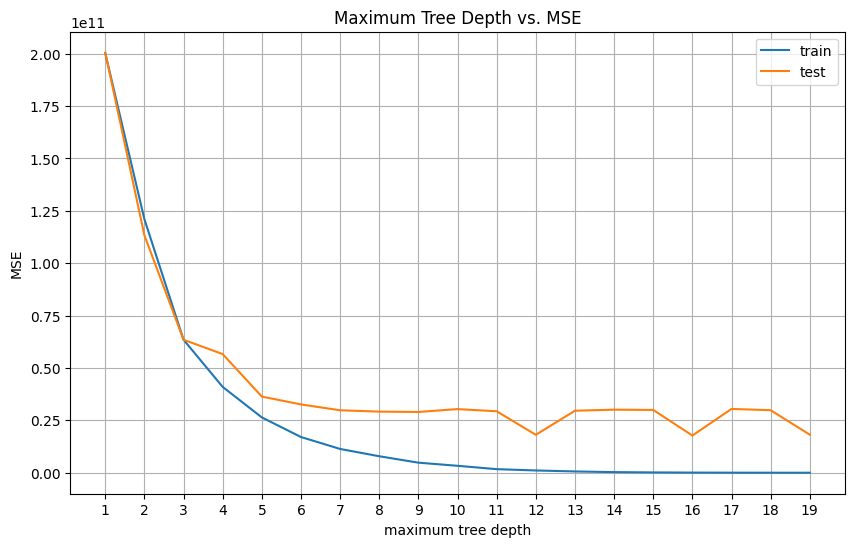

In [2214]:
#plotting test accuracies to find optimal depth
train_scores = []
test_scores = []
min = 1000000000000000000 # just a really high number
best_depth = 0
for i in range(1, 20):
  dt = DecisionTreeRegressor(max_depth = i).fit(X_train_encoded, y_train)
  y_test_preds = dt.predict(X_test_encoded)
  test_scores.append(mean_squared_error(y_test, y_test_preds))
  if (mean_squared_error(y_test, y_test_preds)) < min: #getting the minimum MSE as the best depth
    min = mean_squared_error(y_test, y_test_preds)
    best_depth = i
  y_train_preds = dt.predict(X_train_encoded)
  train_scores.append(mean_squared_error(y_train, y_train_preds))

plt.figure(figsize = (10, 6))
plt.plot(range(1, 20), train_scores, label = 'train')
plt.plot(range(1, 20), test_scores, label = 'test')
plt.xticks(range(1, 20))
plt.grid()
plt.legend()
plt.ylabel('MSE')
plt.xlabel('maximum tree depth')
plt.title('Maximum Tree Depth vs. MSE');

In [2215]:
print(f'Best Depth: {best_depth}') #test it out

Best Depth: 16


In [2216]:
#instantiate the model with best depth
dt_model = DecisionTreeRegressor(max_depth= best_depth)
#build pipeline
dt_pipe = Pipeline([('transformer', transformer), ('model', dt_model)])
#fit
dt_pipe.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['Genre', 'Season'])])),
                ('model', DecisionTreeRegressor(max_depth=16))])

In [2217]:
y_pred = dt_pipe.predict(X_test)
y_pred_train = dt_pipe.predict(X_train)

results.append({
    'Model': 'Decision Tree',
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'Train R2': r2_score(y_train, y_pred_train),
    'Test R2': r2_score(y_test, y_pred),
    'Overfit?': (np.sqrt(mean_squared_error(y_test, y_pred)) > np.sqrt(mean_squared_error(y_train, y_pred_train)))
    })

In [2218]:
#RMSE, R2
print(f'MSE: {(mean_squared_error(y_test, y_pred))}')
print(f'RMSE Test: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'RMSE Train: {np.sqrt(mean_squared_error(y_train, y_pred_train))}')
print(f'Train R^2: {r2_score(y_train, y_pred_train)}')
print(f'Test R^2: {r2_score(y_test, y_pred)}')

MSE: 29328358566.132015
RMSE Test: 171255.2439084188
RMSE Train: 8473.434938996637
Train R^2: 0.9997842017804796
Test R^2: 0.914359961175093


Way too overfit.

In [2219]:
#see which features are important
r = permutation_importance(dt_pipe, X_test, y_test, n_repeats = 10)
pd.DataFrame(r['importances_mean'], index = X_train.columns.tolist())

,0
Avg Ticket,1.229966
Genre,0.035051
Season,0.030966
Seats in Theatre,0.600884


In [2220]:
results

[{'Model': 'Linear Regression',
  'Train RMSE': np.float64(182632.3040452306),
  'Test RMSE': np.float64(158135.5564354657),
  'Train R2': 0.8997500753267593,
  'Test R2': 0.926978935403707,
  'Overfit?': np.False_},
 {'Model': 'Random Forest Regression',
  'Train RMSE': np.float64(80867.61317390707),
  'Test RMSE': np.float64(189213.69897661227),
  'Train R2': 0.9803447709694341,
  'Test R2': 0.8954571705672739,
  'Overfit?': np.True_},
 {'Model': 'KNN',
  'Train RMSE': np.float64(131726.2172386768),
  'Test RMSE': np.float64(127492.02854343074),
  'Train R2': 0.9478477200104081,
  'Test R2': 0.9525370026723889,
  'Overfit?': np.False_},
 {'Model': 'Decision Tree',
  'Train RMSE': np.float64(8473.434938996637),
  'Test RMSE': np.float64(171255.2439084188),
  'Train R2': 0.9997842017804796,
  'Test R2': 0.914359961175093,
  'Overfit?': np.True_}]

In [2221]:
results_df = pd.DataFrame(results)
results_df

,Model,Train RMSE,Test RMSE,Train R2,Test R2,Overfit?
0,Linear Regression,182632.304045,158135.556435,0.899750,0.926979,False
1,Random Forest Regression,80867.613174,189213.698977,0.980345,0.895457,True
2,KNN,131726.217239,127492.028543,0.947848,0.952537,False
3,Decision Tree,8473.434939,171255.243908,0.999784,0.914360,True


Conclusion: KNN is my best model. Lowest error without overfitting.